## 개발환경

In [1]:
import platform
platform.platform()
!cat /etc/issue.net
!python --version
!nvidia-smi

Ubuntu 20.04.5 LTS
Python 3.9.16
Tue Mar 21 14:01:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                       

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
! pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import

In [42]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import numpy as np

#Sampling
from imblearn.over_sampling import BorderlineSMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier



In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

class CFG:
  SEED = 37

seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [8]:
train_df = pd.read_csv('./drive/MyDrive/lg2/train.csv')
test_df = pd.read_csv('./drive/MyDrive/lg2/test.csv')

In [9]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

<BarContainer object of 3 artists>

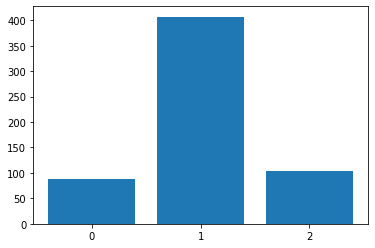

In [33]:
plt.bar(['0','1','2'],train_y.value_counts().sort_index())

## Data Pre-processing

In [34]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [35]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


In [57]:
# category(int) / float feature
def feature_type(df,use_iloc = False):
    """
    use_iloc : 
        dataframe columns type. 
        
        ex.
            df.col or df[col] ->  False 
            df.iloc[:,col] -> True 
    """
    cate_features = []
    drop_features =[]
    float_features =[]

    for i,col in enumerate(df.columns):
        isfloat = False
        for j,v in enumerate(df[col].unique()):
            try:
                if not v.is_integer():
                    isfloat = True
                    break
            except:
                if not type(v) == np.int32:
                    isfloat = True
                    break
        if not isfloat:
            if j > 1:
                cate_features.append(i if use_iloc else col)
            else :
                if df[col].unique()[0] == -1:
                    drop_features.append(i if use_iloc else col) # not use
            # print(f"{col} unique : {df[col].unique()}")    
        # 정수를 제외한 float feature
        else:
            float_features.append(i if use_iloc else col)   
            # 전체 평균
            # df[col] = train_df[col].fillna(df[col].mean()) # nan 값 제외한 평균
            # # 클래스 별 평균
            # for k in range(3):
            #     df[col] = train_df[[col,'Y_Class']][train_df['Y_Class']==k].mean()[0]
    print(len(cate_features),len(drop_features),len(float_features))
    return cate_features,drop_features,float_features
a = feature_type(train_x,True)

6 3 2549


In [58]:
a[0]

[0, 1, 246, 700, 2464, 2777]

In [65]:
train_x.iloc[:,700].value_counts()

0.0     1211
29.0       8
52.0       1
60.0       1
Name: X_699, dtype: int64

## SMOTE

In [43]:
# Class 불균형 문제 해결
train_x,train_y = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(train_x,train_y)

## Classification Model Fit

In [36]:
models = [
    ('bag', BaggingClassifier(random_state=CFG.SEED)),
    ('dt', DecisionTreeClassifier(random_state=CFG.SEED)),
    ('rc', RidgeClassifier(random_state=CFG.SEED)),
    ('xgb', XGBClassifier(random_state=CFG.SEED)),
    ('lgb', LGBMClassifier(random_state=CFG.SEED)),
    ('gb', GradientBoostingClassifier(random_state=CFG.SEED)),
    ('svc', SVC(random_state=CFG.SEED)),
    ('rcc', RidgeClassifierCV()),
    ('rf', RandomForestClassifier(random_state=CFG.SEED))
]

In [44]:
#최종모델은 Votingclassifier 사용하여 ensemble -> 제출결과 public score기준 XGBClassifier와 RandomForestClassifier 성능이 좋아 가중치를 주었음
best_model  = VotingClassifier(models, voting='hard', weights=[1,1,1,2,1,1,1,1,2])
best_model.fit(train_x,train_y)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


VotingClassifier(estimators=[('bag', BaggingClassifier(random_state=37)),
                             ('dt', DecisionTreeClassifier(random_state=37)),
                             ('rc', RidgeClassifier(random_state=37)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_me...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=37, ...)),
                             ('lgb', LGBMClassifier(random_state=37)),
                             ('gb',
                              GradientBoostingClassifier(random_state=37)),
                             ('svc', SVC(random_state=37)),
                             ('rcc', RidgeClassifierCV()),
                             ('rf', RandomForestClassifier(random_state=37))],
                 weights=[1, 1, 1, 2, 1, 1, 1, 1, 2])

## Inference

In [45]:
preds = best_model.predict(test_x.to_numpy())
print('Done.')

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RidgeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Done.


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RidgeClassifierCV was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [46]:
for i in range(3):
  print(len(preds[preds == i]))

40
253
17


## Submit

In [47]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M")
os.makedirs('./result',exist_ok=True)
submit = pd.read_csv('./drive/MyDrive/lg2/sample_submission.csv')
submit['Y_Class'] = preds
submit.to_csv(f'./drive/MyDrive/lg2/result/baseline_submission_{formatted_datetime}.csv', index=False)